# Задание 1. Bootstrap

В этом задании используйте датасет breast_cancer — классический датасет для задачи бинарной классификации. Обучите модели:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`.

Параметры моделей можете оставить по умолчанию или задать сами.

Для каждой модели посчитайте [корреляцию Мэтьюса](https://en.wikipedia.org/wiki/Phi_coefficient) — метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, ([`sklearn.metrics.matthews_corrcoef`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), подробнее почитать про его пользу можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) — для предсказанного ею класса и реального.

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей. Используйте функцию `bootstrap_metric()` из лекции.

Постройте [боксплоты](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей.

Импорт необходимых библиотек:

In [ ]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

Загрузка датасета:

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

In [ ]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
# Your code here
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
lgbm = lightgbm.LGBMClassifier()
svc = SVC()
bagsvc = BaggingClassifier(estimator=SVC())

models = [dtc, rfc, lgbm, svc, bagsvc]

In [ ]:
metrics = []
preds = []

for model in models:
    model.fit(x_train, y_train)
    preds.append(model.predict(x_test))
    metrics.append(matthews_corrcoef(y_test, preds[-1]))


In [ ]:
print(metrics)

[0.8963356530877563, 0.940477037066757, 0.8963356530877563, 0.8965050191922527, 0.8965050191922527]


In [ ]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [ ]:
boot_scores = [bootstrap_metric(y_test, pred,
                                metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y))
               for pred in preds]

alpha = 0.10
names = ['DecisionTree', 'RandomForest', 'LightGBM', 'SVC', 'BaggingSVC']

for i, name in enumerate(names):
    print(
        f"Matthews correlation for the {name} model: ",
        np.quantile(boot_scores[i], q=[alpha / 2, 1 - alpha / 2]),
    )


Matthews correlation for the DecisionTree model:  [0.83061697 0.955936  ]
Matthews correlation for the RandomForest model:  [0.88953352 0.98517822]
Matthews correlation for the LightGBM model:  [0.82950665 0.95459809]
Matthews correlation for the SVC model:  [0.83030554 0.95532067]
Matthews correlation for the BaggingSVC model:  [0.83030554 0.95532067]


По доверительным интервалам можно сделать вывод, что в данной задаче все модели, кроме RandomForest работают примерно с одинаковым качеством. RandomForest все же выделяется на фоне остальных моделей, доверительный интервал для его качества смещен на 0.06 вправо по отношению к доверительным интервалам для качеств всех остальных моделей.

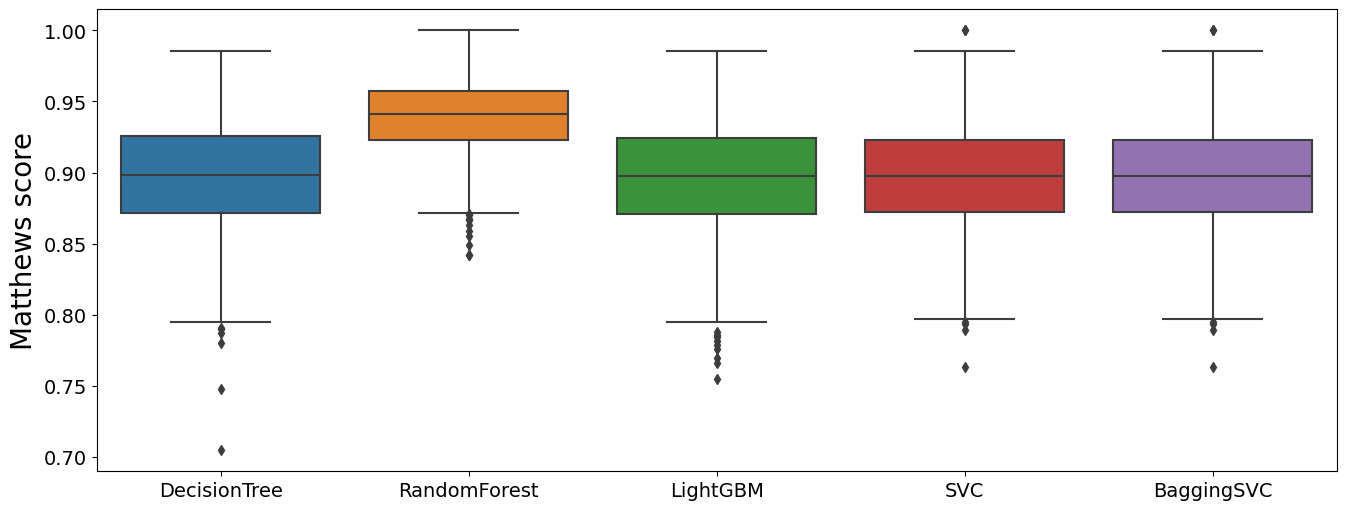

In [ ]:
xticks = []
for name in names:
    xticks += [name] * 1000

plt.figure(figsize=(16, 6))
sns.boxplot(
    y=np.concatenate(boot_scores),
    x=xticks,
)
plt.ylabel("Matthews score", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Сделайте вывод о том, какие модели работают лучше.

**Напишите вывод**

Видно, что RandomForest работает лучше, чем остальные модели.

## Формат результата

График с демонстрацией корреляции Мэтьюса для следующих моделей:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX03/result_1_task_ex03.png" width="600">

# Задание 2. Дисбаланс классов

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -qU imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_validate,
)

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [ ]:
real_labels = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, а 5 — к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [ ]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [ ]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy (см. лекцию 1) для этих моделей:

In [ ]:
print("Accuracy for model1: ", accuracy_score(real_labels, model1_res))
print("Accuracy for model2: ", accuracy_score(real_labels, model2_res))

Accuracy for model1:  0.7619047619047619
Accuracy for model2:  0.7619047619047619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [ ]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print(
    "Balanced accuracy for model1: ", balanced_accuracy_score(real_labels, model1_res)
)
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print(
    "Balanced accuracy for model2: ", balanced_accuracy_score(real_labels, model2_res)
)

Balanced accuracy for model1:  0.5
Balanced accuracy for model2:  0.775


**Всегда проверяйте**, являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли), и 0, если не ответил. Количество пациентов, отвечающих на терапию, сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров — актуальная задача в онкологии. В данном задании вам предстоит попробовать её решить.

In [ ]:
cancer = pd.read_table(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Cancer_dataset_2.tsv",
    index_col="sample_id",
)
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer["Response"]
x = cancer.drop("Response", axis=1)
print("\nNumber of patients responded to immunotherapy:")
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


0    228
1     37
Name: Response, dtype: int64

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ &mdash; это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ &mdash; это использование специальных алгоритмов, учитывающих несбалансированность классов.


В данном задании вам нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого вы будете использовать три модели, представленные ниже:

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn — меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn — сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Оцените эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, используйте значения `accuracy` и `balanced_accuracy`. Проинтерпретируйте результаты.

In [ ]:
rfc = RandomForestClassifier()
rfcb = RandomForestClassifier(class_weight='balanced')
imbrfc = imblearn.ensemble.BalancedRandomForestClassifier()

In [ ]:
scoring = ('accuracy', 'balanced_accuracy')
cv_results_rfc = [cross_validate(rfc, x, y, cv=KFold(shuffle=True), scoring=scoring),
                  cross_validate(rfc, x, y, cv=StratifiedKFold(shuffle=True), scoring=scoring)]

cv_results_rfcb = [cross_validate(rfcb, x, y, cv=KFold(shuffle=True), scoring=scoring),
                  cross_validate(rfcb, x, y, cv=StratifiedKFold(shuffle=True), scoring=scoring)]

cv_results_imbrfc = [cross_validate(imbrfc, x, y, cv=KFold(shuffle=True), scoring=scoring),
                  cross_validate(imbrfc, x, y, cv=StratifiedKFold(shuffle=True), scoring=scoring)]


In [ ]:
acc_kfold = []
acc_stratified = []
bal_acc__kfold = []
bal_acc_stratified = []

for res in (cv_results_rfc, cv_results_rfcb, cv_results_imbrfc):
    acc_kfold.append(np.mean(res[0]['test_accuracy']))
    acc_stratified.append(np.mean(res[1]['test_accuracy']))
    bal_acc__kfold.append(np.mean(res[0]['test_balanced_accuracy']))
    bal_acc_stratified.append(np.mean(res[1]['test_balanced_accuracy']))

In [ ]:
scores = pd.DataFrame(columns=['RFC', 'RFC_bal', 'imb_RFC'])
scores.loc['Acc_KFold'] = acc_kfold
scores.loc['Acc_Strat'] = acc_stratified
scores.loc['Bal_Acc_KFold'] = bal_acc__kfold
scores.loc['Bal_Acc_Strat'] = bal_acc_stratified
scores

,RFC,RFC_bal,imb_RFC
Acc_KFold,0.852830,0.860377,0.660377
Acc_Strat,0.867925,0.864151,0.686792
Bal_Acc_KFold,0.535186,0.529167,0.669655
Bal_Acc_Strat,0.559405,0.545167,0.692222


Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы cross_validate нужно перемешать данные. Для этого используйте флаг `shuffle=True`, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции cross_validate).

Какая модель лучше справляется с дисбалансом классов?

**Напишите вывод**

Модель BalancedRandomForestClassifier из библиотеки imblearn показывает качество balanced accuracy лучше двух других моделей, при этом это качество наилучшее при использовании стратифицированного разбиения.

## Формат результата

Получить значения `accuracy` и `balanced_accuracy`для моделей:
1. `RandomForestClassifier`, библиотека sklearn;
2. `RandomForestClassifier с балансировкой классов`, библиотека sklearn;
3. `BalancedRandomForestClassifier`, библиотека imblearn.


# Задание 3. Разные типы бустингов

В этом задании будем использовать датасет с рейтингом блюд по некоторым характеристикам.

В некоторых реализациях градиентного бустинга есть возможность использовать другой метод обучения. Например, в XGB есть тип `dart`, а в lgbm — `goss`. Это позволяет составлять более эффективные ансамбли.

Используя кросс-валидацию (используйте 3 фолда), обучите модели:
* CatboostRegressor
* XGBRegressor
* LGBMRegressor

Сохраните модель на каждом фолде и посчитайте `mse` для тестовой выборки, используя модель с каждого фолда. Получите предсказания всех 9 моделей на тестовой выборке и усредните их. Затем посчитайте `mse` для усредненных предсказаний.

Напишите выводы о полученном качестве моделей.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.3 MB/s eta 0:00:00


In [ ]:
import xgboost
import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)
recipies

,calories,protein,fat,sodium,cakeweek,wasteless,rating
0,426.0,30.0,7.0,559.0,0.0,0.0,2.500
1,403.0,18.0,23.0,1439.0,0.0,0.0,4.375
2,165.0,6.0,7.0,165.0,0.0,0.0,3.750
3,547.0,20.0,32.0,452.0,0.0,0.0,3.125
4,948.0,19.0,79.0,1042.0,0.0,0.0,4.375
...,...,...,...,...,...,...,...
15859,28.0,2.0,2.0,64.0,0.0,0.0,3.125
15860,671.0,22.0,28.0,583.0,0.0,0.0,4.375
15861,563.0,31.0,38.0,652.0,0.0,0.0,4.375
15862,631.0,45.0,24.0,517.0,0.0,0.0,4.375


In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train_all, x_test, y_train_all, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)
models = []

for i, (train_index, test_index) in enumerate(kf.split(x_train_all)):
    x_train, y_train = x_train_all[train_index], y_train_all[train_index]
    xgb = xgboost.XGBRegressor(booster='dart', rate_drop=0.2, one_drop=1, verbosity=0)
    lgbm = lightgbm.LGBMRegressor(data_sample_strategy='goss', top_rate=0.2, other_rate=0.1, verbosity=-1)
    catbst = catboost.CatBoostRegressor(verbose=False)

    xgb.fit(x_train, y_train)
    lgbm.fit(x_train, y_train)
    catbst.fit(x_train, y_train)

    models += [xgb, lgbm, catbst]

In [ ]:
preds = [model.predict(x_test) for model in models]
mse_scores = [mse(y_test, pred) for pred in preds]

In [ ]:
print('XGB scores: ', ', '.join(map(str, mse_scores[::3])), f', mean={np.mean(mse_scores[::3])}')
print('LGBM scores: ', ', '.join(map(str, mse_scores[1::3])), f', mean={np.mean(mse_scores[1::3])}')
print('CatBoost scores: ', ', '.join(map(str, mse_scores[2::3])), f', mean={np.mean(mse_scores[2::3])}')

XGB scores:  1.5543125000372546, 1.5716602572572507, 1.5521523765738354 , mean=1.5593750446227803
LGBM scores:  1.610493311177405, 1.600718557352586, 1.5992510617506628 , mean=1.6034876434268845
CatBoost scores:  1.5627819275715273, 1.5667554291281447, 1.5584688013584853 , mean=1.5626687193527191


видно, что наименьшее значение mse получилось для xgboost.

In [ ]:
np_preds = np.array(preds)

In [ ]:
avg_pred = np.mean(np_preds, axis=0)

In [ ]:
print(f'Averaged prediction score: {mse(y_test, avg_pred)}')

Averaged prediction score: 1.5250031956091585


Видно, что простое усреднение ответов разных моделей дало небольшой прирост в качестве предсказания, уменьшив среднеквадратичную ошибку на 0.034.

## Формат результата

Получить значения MSE для всех моделей и значение MSE, усреднив предсказания всех моделей. Написать вывод.


# Задание 4. Подбор гиперпараметров

В этом задании нужно подобрать параметры для бустинга `CatBoostRegressor`, используя библиотеку `optuna`. И улучшить результат по сравнению со стандартными параметрами.

Список параметров для подбора:

* `depth`
* `iterations`
* `learning_rate`
* `colsample_bylevel`
* `subsample`
* `l2_leaf_reg`
* `min_data_in_leaf`
* `max_bin`
* `random_strength`
* `bootstrap_type`

**Важно!** *Подбирать параметры нужно на валидационной выборке*

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from optuna.samplers import RandomSampler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)

In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
model = CatBoostRegressor(random_seed=42)

model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

print("\nmse_score before tuning: ", mse(y_test, model.predict(x_test)))

Learning rate set to 0.074308
0:	learn: 1.2817437	test: 1.2774827	best: 1.2774827 (0)	total: 9.72ms	remaining: 9.71s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.242760353
bestIteration = 44

Shrink model to first 45 iterations.

mse_score before tuning:  1.5444532948674852


In [ ]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [ ]:
x_train_search, x_val, y_train_search, y_val = train_test_split(
    x_train, y_train, train_size=0.6, random_state=42
)

In [ ]:
# Your code here
def objective(trial):
    # boundaries for the optimizer's
    depth = trial.suggest_int("depth", 5, 9, step=1)
    iterations = trial.suggest_int("iterations", 500, 3000, step=500)
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01, 0.03, 0.1, 0.5, 1])
    colsample_bylevel = trial.suggest_categorical("colsample_bylevel", [0.1, 0.2, 0.4, 0.5, 0.7, 1])
    subsample = trial.suggest_categorical("subsample", [0.4, 0.6, 0.8])
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ['Bernoulli', 'MVS'])

    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 6, 14, step=2)
    l2_leaf_reg = trial.suggest_categorical("l2_leaf_reg", [2, 5, 7, 10])
    random_strength = trial.suggest_float("random_strength", 1, 4)
    max_bin = trial.suggest_categorical("max_bin", [16, 32, 64, 128, 254, 512])


    # create new model(and all parameters) every iteration
    model = catboost.CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        colsample_bylevel=colsample_bylevel,
        subsample=subsample,
        bootstrap_type=bootstrap_type,
        min_data_in_leaf=min_data_in_leaf,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        max_bin=max_bin,
        random_state=42,
        verbose=0,
    )

    model.fit(x_train_search, y_train_search)
    y_pred = model.predict(x_val)
    boot_score = bootstrap_metric(
        y_val,
        y_pred,
        metric_fn=lambda x, y: mse(y_true=x, y_pred=y),
    )

    return boot_score.mean()


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=RandomSampler(42)
)

study.optimize(
    objective, n_trials=80
)

[I 2023-10-28 12:47:39,389] A new study created in memory with name: Optimizer
[I 2023-10-28 12:47:42,525] Trial 0 finished with value: 2.0804118372307836 and parameters: {'depth': 6, 'iterations': 3000, 'learning_rate': 1, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'l2_leaf_reg': 2, 'random_strength': 2.3682099526511076, 'max_bin': 16}. Best is trial 0 with value: 2.0804118372307836.
[I 2023-10-28 12:47:43,431] Trial 1 finished with value: 1.531768940505674 and parameters: {'depth': 5, 'iterations': 500, 'learning_rate': 0.01, 'colsample_bylevel': 0.7, 'subsample': 0.4, 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'l2_leaf_reg': 5, 'random_strength': 3.7656227050693505, 'max_bin': 254}. Best is trial 1 with value: 1.531768940505674.
[I 2023-10-28 12:47:46,233] Trial 2 finished with value: 2.4235524165798052 and parameters: {'depth': 9, 'iterations': 1500, 'learning_rate': 1, 'colsample_bylevel': 0.5, 'subsample': 0.4, 'b

In [ ]:
model = catboost.CatBoostRegressor(
        iterations=study.best_params['iterations'],
        learning_rate=study.best_params['learning_rate'],
        depth=study.best_params['depth'],
        colsample_bylevel=study.best_params['colsample_bylevel'],
        subsample=study.best_params['subsample'],
        bootstrap_type=study.best_params['bootstrap_type'],
        min_data_in_leaf=study.best_params['min_data_in_leaf'],
        l2_leaf_reg=study.best_params['l2_leaf_reg'],
        random_strength=study.best_params['random_strength'],
        max_bin=study.best_params['max_bin'],
        random_state=42,
        verbose=0,
        )

model.fit(x_train, y_train)
print("\nmse_score after tuning: ", mse(y_test, model.predict(x_test)))


mse_score after tuning:  1.5330083685241194


mse получился чуть меньше (на 0.011), чем до настройки гиперпараметров

## Формат результата

Значение `mse` с подобранными параметрами меньше, чем при стандартных параметрах.

# Задание 5. Ансамблевое обучение (Дополнительно)

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci).

Установка и импорт необходимых библиотек:

In [1]:
!pip install -q catboost
!pip install -q lightgbm==3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.5 MB/s eta 0:00:00


In [34]:
import catboost
import lightgbm
import xgboost
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, f1_score
import itertools
import scipy

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)

Загрузка датасета:

In [3]:
heart_dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/heart.csv "
)

In [58]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [59]:
rng = np.random.RandomState(42)

dt = DecisionTreeClassifier(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
etc = ExtraTreesClassifier(random_state=rng)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
svc_lin = SVC(kernel='linear', probability=True, random_state=rng)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=rng)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=42)
lgbm = lightgbm.LGBMClassifier(random_state=42, verbosity=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", subsample_freq=1,subsample=0.7, random_state=42, verbosity=-1)
xgb = xgboost.XGBClassifier(random_state=42)
xgb_rf = xgboost.XGBRFClassifier(random_state=42)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

# Your code here
estimators_names = ['dt', 'rf', 'etc', 'knn', 'svc_lin', 'svc_rbf',
                    'cat', 'lgbm', 'lgbm_rf', 'xgb', 'xgb_rf', 'lr', 'nb']
estimators = [dt, rf, etc, knn, svc_lin, svc_rbf,
              cat, lgbm, lgbm_rf, xgb, xgb_rf, lr, nb]

voting_hard = VotingClassifier(estimators=list(zip(estimators_names, estimators)),
                               voting='hard')
voting_soft = VotingClassifier(estimators=list(zip(estimators_names, estimators)),
                               voting='soft')
# -----------

for model in [voting_hard, voting_soft]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

VotingClassifier: 0.8051977097870817
VotingClassifier: 0.8087743929648131


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них, не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тренировочном наборе и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Можете модифицировать функцию `base_model_pair_correlation` из лекции.

In [60]:
for model in [voting_hard, voting_soft]:
    model.fit(x_train, y_train)

print(f'Качество на тестовой выборке модели hard: {f1_score(y_test, voting_hard.predict(x_test))}')
print(f'Качество на тестовой выборке модели soft: {f1_score(y_test, voting_soft.predict(x_test))}')

Качество на тестовой выборке модели hard: 0.8470588235294119
Качество на тестовой выборке модели soft: 0.8470588235294119


In [62]:
def make_corr(ensemble, estim_names, correlation_type, x, y, with_target=False):
    preds = pd.DataFrame(columns=estim_names)
    for i, estimator in enumerate(ensemble.estimators_):
        preds[estim_names[i]] = estimator.predict_proba(x)[:, 1]

    if with_target:
        preds['target'] = y

    if correlation_type in ['pearson', 'kendall', 'spearman']:
        return preds.corr(method=correlation_type).abs()
    elif correlation_type == 'matthews':
        for i, estimator in enumerate(ensemble.estimators_):
            preds[estim_names[i]] = estimator.predict(x)
        return preds.corr(method=matthews_corrcoef).abs()

<Axes: >

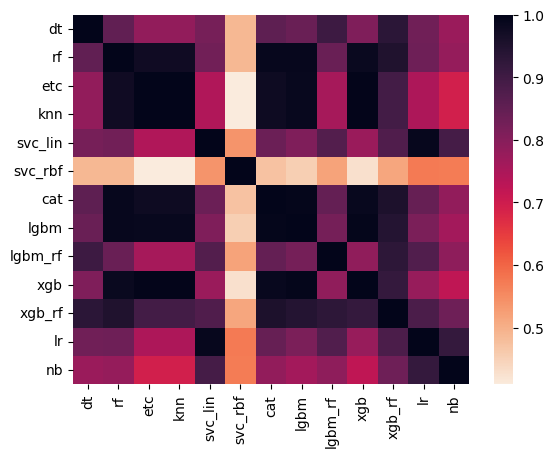

In [63]:
sns.heatmap(make_corr(voting_hard, estimators_names, 'pearson', x_train, y_train, with_target=False), cmap="rocket_r")

<Axes: >

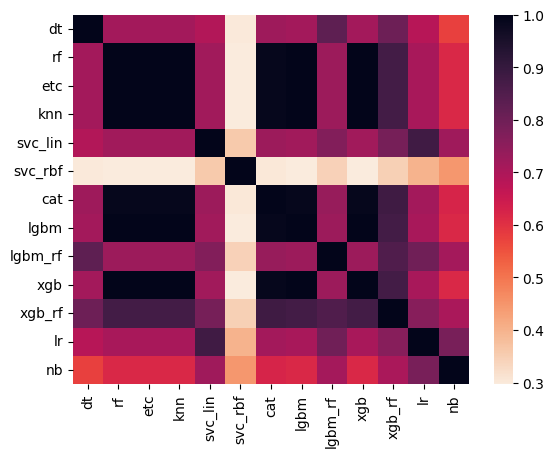

In [16]:
sns.heatmap(make_corr(voting_hard, estimators_names, 'matthews', x_train), cmap="rocket_r")

In [64]:
corr_hard = make_corr(voting_hard, estimators_names, 'pearson', x_train, y_train, with_target=False)
corr_soft = make_corr(voting_soft, estimators_names, 'pearson', x_train, y_train, with_target=False)

Далее я пробовал 2 разных способа для удаления коррелированных моделей.

In [65]:
def find_correlated(corr_matrix, threshold):
    correlated_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] > threshold) and (corr_matrix.columns[j] not in correlated_features):
                colname = corr_matrix.columns[i]
                correlated_features.add(colname)

    return list(correlated_features)

In [66]:
from collections import Counter

def find_correlated_2(corr_matrix, threshold):
    abs_corr_matrix = corr_matrix.copy()
    filtered_cols = []

    while True:
        offenders = []
        for i in range(len(abs_corr_matrix)):
            for j in range(len(abs_corr_matrix)):
                if i != j:
                    if abs_corr_matrix.iloc[i,j] > threshold:
                        offenders.append(abs_corr_matrix.columns[i])

        if len(offenders) > 0: # if at least one high correlation remains
            c = Counter(offenders)
            worst_offender = c.most_common(1)[0][0]  # var name of worst offender
            filtered_cols.append(worst_offender)
            abs_corr_matrix.drop(worst_offender, axis=0, inplace=True) #drop from x-axis
            abs_corr_matrix.drop(worst_offender, axis=1, inplace=True) #drop from y-axis
        else: # if no high correlations remain, break
            break

    return filtered_cols

In [48]:
find_correlated(corr_hard, 0.90)

['cat', 'lr', 'xgb', 'lgbm', 'knn', 'etc', 'lgbm_rf', 'xgb_rf']

In [45]:
find_correlated_2(corr_hard, 0.95)

['cat', 'rf', 'etc', 'knn', 'svc_lin', 'lgbm']

In [67]:
len(voting_hard.estimators_)

13

In [68]:
models_to_drop_hard = find_correlated(corr_hard, 0.90)
#models_to_drop_hard_2 = find_correlated_2(corr_hard, 0.90)
models_to_drop_soft = find_correlated(corr_soft, 0.90)
#models_to_drop_soft_2 = find_correlated_2(corr_soft, 0.90)

Далее старые графики, которые не запустятся в новой версии

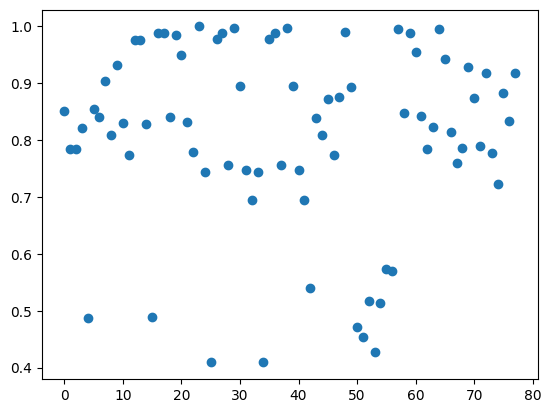

In [ ]:
plt.scatter(range(len(corr_hard)), corr_hard)

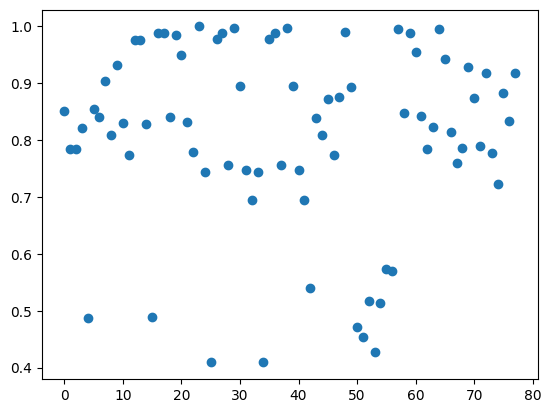

In [ ]:
plt.scatter(range(len(corr_soft)), corr_soft)

In [69]:
params_hard = {el: 'drop' for el in models_to_drop_hard}
#params_hard_2 = {el: 'drop' for el in models_to_drop_hard_2}
params_soft = {el: 'drop' for el in models_to_drop_soft}
#params_soft_2 = {el: 'drop' for el in models_to_drop_soft_2}

Создайте новый ансамбль, на исправленном наборе моделей и оцените его качество с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [70]:
# Your code here

voting_hard_new = voting_hard.set_params(**params_hard)
voting_soft_new = voting_soft.set_params(**params_soft)
#voting_hard_new_2 = voting_hard.set_params(**params_hard_2)
#voting_soft_new_2 = voting_soft.set_params(**params_soft_2)


for model in [voting_hard_new, voting_soft_new]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

VotingClassifier: 0.8508610892560539
VotingClassifier: 0.8369167840669203


Обучите все получившиеся модели на тренировочном наборе и испытайте их качество на тестовом наборе. Получилось ли у улучшенных версий ансамблевого классификатора превзойти базовые модели, входящие в него, и свои предыдущие версии?

In [71]:
# Your code here
for model in [voting_hard_new, voting_soft_new]:
    model.fit(x_train, y_train)

print(f'Качество на тестовой выборке новой модели hard: {f1_score(y_test, voting_hard_new.predict(x_test))}')
print(f'Качество на тестовой выборке новой модели soft: {f1_score(y_test, voting_soft_new.predict(x_test))}')

Качество на тестовой выборке новой модели hard: 0.8941176470588236
Качество на тестовой выборке новой модели soft: 0.8674698795180722


Видно, что улучшенные версии ансамблей превосходят по качеству на тестовой выборке свои предыдущие версии. При удалении скоррелированных моделей ансамбль с voting=hard показал улучшение качества на 0.05, в то время как soft версия только на 0.02. (что довольно интересно, учитывая что в изначальных версиях качество этих ансамблей на тестовой выборке было одинаковым, а список удаленных моделей для hard и soft версии также были одинаковыми)

In [78]:
len(voting_hard_new.estimators_)

5

Посмотрим наконец на качество на тесте для базовых моделей.

In [76]:
for i, model in enumerate(estimators):
    model.fit(x_train, y_train)
    print(f'Качество на тестовой выборке модели {estimators_names[i]}: {f1_score(y_test, model.predict(x_test)):.4f}')

Качество на тестовой выборке модели dt: 0.8333
Качество на тестовой выборке модели rf: 0.8293
Качество на тестовой выборке модели etc: 0.8675
Качество на тестовой выборке модели knn: 0.7381
Качество на тестовой выборке модели svc_lin: 0.8810
Качество на тестовой выборке модели svc_rbf: 0.7629
Качество на тестовой выборке модели cat: 0.8333
Качество на тестовой выборке модели lgbm: 0.8193
Качество на тестовой выборке модели lgbm_rf: 0.8864
Качество на тестовой выборке модели xgb: 0.8333
Качество на тестовой выборке модели xgb_rf: 0.8333
Качество на тестовой выборке модели lr: 0.8810
Качество на тестовой выборке модели nb: 0.8889


В результате получили, что для улучшенной версии ансамбля с voting=hard качество на тестовой выборке превзошло как свою предыдущую версию, так и базовые модели. При этом есть базовые модели, качество которых выше, чем у предыдущей версии ансамбля.

Какие ансамбли работают лучше? Всегда ли больше моделей значит лучше?

**Напишите вывод**

На кросс-валидации ансамбли с меньшим числом моделей (после того, как убрали скоррелированные модели) показывают лучшее качество по сравнению с изначальным вариантом.

## Формат результата

Получить значения качества для ансамблей и моделей.